In [115]:
from keras import Model
from keras import layers
import keras
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from pathlib import Path
import numpy as np

from keras.applications import vgg19

In [116]:
# Setup if running in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  try:
    if runonce:
      print("Already ran")
  
  except:
    runonce = True
    !git clone https://github.com/Jimmy-Nnilsson/StudieGrupp3_MLProjekt.git
    

In [117]:
def seed_everything():
    # os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    random.seed(1254)
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

In [118]:
# Get base project directory
if not RunningInCOLAB:
#   project_path = Path(os.getcwd()).parent.parent

  for i, p in enumerate(Path(os.getcwd()).parts):
    if p == "StudieGrupp3_MLProjekt":
        break
    pathparts = list(Path(os.getcwd()).parts[0:i+2])
    project_path = Path(pathparts[0],"\\\\".join(pathparts[1:]))
else:
  project_path = Path('/content/StudieGrupp3_MLProjekt/')
datapath = (project_path /'data/')

CLASSES = {0 : 'no', 1 : 'yes'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        
        data.append(image)
    data = np.asarray(data, dtype=np.uint8)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        new_path = (datapath / f"processed/2_split_{v}/{subfolder}")
        folder_paths += list((new_path).rglob("*"))
        list_len = len(list((new_path).rglob("*")))
        folder_labels += [k for i in range(list_len)]
        
    # Label data generation
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    ohe_folder_labels = tf.keras.utils.to_categorical(folder_labels, len(CLASSES))
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels, ohe_folder_labels

def get_training_set(subfolder, CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        
        new_path = (datapath / f"processed_dataset_2/3_split_{v}/{subfolder}/")
        folder_paths += list((new_path).rglob("*"))
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    ohe_folder_labels = tf.keras.utils.to_categorical(folder_labels, len(CLASSES))
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels, ohe_folder_labels

Load Pictures

In [119]:
# Dataset inspect
# Read images to variables

size = 224
X_train, y_train, y_train_ohe = get_sets('train', CLASSES, size)
X_val, y_val, y_val_ohe = get_sets('val', CLASSES, size)
X_test, y_test, y_test_ohe = get_sets('test', CLASSES, size)


Data loader

In [120]:
#@title
@tf.function
def preprocess(image: tf.Tensor, label: tf.Tensor):
    """
    Preprocess the image tensors and parse the labels
    """
    # Preprocess images
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Parse label
    label = tf.cast(label, tf.float32)

    return image, label


def prepare_dataloader(images: np.ndarray,
                       labels: np.ndarray,
                       loader_type: str='train',
                       batch_size: int=128):
    """
    Utility function to prepare dataloader.
    """
    images = model_preprocess(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if loader_type=='train':
        dataset = dataset.shuffle(1024)

    dataloader = (
        dataset
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader

def model_preprocess(images):
    images = vgg19.preprocess_input(images)
    return images

Config parameters

In [121]:
# Mind model processing
# Finetune not complete
configs = dict(
    project_name = "MRI_Baseline_3", #Project Name
    mode = 'disabled', #{'offline', 'run', 'disabled', 'dryrun', 'online'} # WandB run status
    job_type = "", #Run type for WandB
    group = "", # Group in WandB
    sub_group = "_s2_twostep",

    class_names = CLASSES, # Classes for training
    training_set = "",

    image_width = X_train[0].shape[0], # Picture width for model input
    image_height = X_train[0].shape[1], # Picture height for model input
    image_channels = X_train[0].shape[2], # Picture channels for model input

    pretrain_weights = 'imagenet', # pretrained weights for basemodel if any
    batch_size = 4, # Batchsize for training
    init_learning_rate = 0.0004, # Initial training rate if no callback is used
    lr_decay_rate = 0.1, #decayrate of training rate
    epochs = 50, # Epochs to train
    optimizer = 'rmsprop', # The optimizer used by the ml model
    loss_fn = 'CategoricalCrossentropy', # Loss function
    metrics = ['accuracy', 'CategoricalCrossentropy'], # Metrics
    earlystopping_patience = 5, # For the early stopping callback

    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection",
    fine_tune_learning_rate = 3e-5, # learningrate Used during fine tuning
    fine_tune_epochs = 10, # Epochs ran at finetuning

    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    model_name = '' # set after model is defined # Name of the ml Model

)

In [141]:
def get_preprocess():
    inputs = layers.Input(shape=(224,224,3))
    x = vgg19.preprocess_input(inputs)
    x = layers.Resizing(224,224)(x)
    return Model(inputs, x, name="Pro")


In [142]:
preprocess_model = get_preprocess()

In [154]:
def get_vgg19():
    tf.keras.backend.clear_session()
    kwarg = dict(weights=configs['pretrain_weights'], include_top=False, input_shape=(224,224,3))
    base_model = vgg19.VGG19(**kwarg)

    return Model(base_model.input, base_model.output, name=f'vgg19')

In [155]:
vgg19_model = get_vgg19()

In [157]:
inputs = preprocess_model.input
x = preprocess_model(inputs)
x = vgg19_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(2, activation='softmax')(x)

test = Model(inputs, x)
test.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Pro (Functional)            (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                           

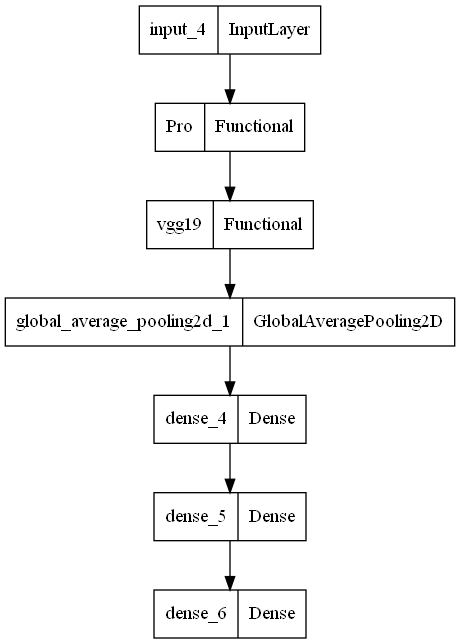

In [158]:
tf.keras.utils.plot_model(test)